In [1]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pprint import pprint


#Spark imports
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
import os
import sys


# Start a SparkSession
import findspark
findspark.init()


%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=857f4e2ce55e55d766b7165586dbda8409804013eb8218a809aed3cbe4fb55da
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

In [3]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
url = "https://aws-project-4.s3.ca-central-1.amazonaws.com/heart_attack_prediction_dataset.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("heart_attack_prediction_dataset.csv"), sep=",", header=True)
df.show()

+----------+---+------+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-----------------------+------+------------------+-------------+-------------------------------+-------------------+-------------+-------------+-------------------+-----------------+
|Patient ID|Age|   Sex|Cholesterol|Blood Pressure|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|Income|               BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|      Country|    Continent|         Hemisphere|Heart Attack Risk|
+----------+---+------+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-------------

In [4]:
# Convert PySpark DataFrame to Pandas DataFrame for display options
pd_df = df.toPandas()

# Set display options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.precision", 2)

# Display the DataFrame
pd_df.head(10)

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,0,4.168188835442079,Average,0,0,9,6.6150014529140595,261404,31.251232725295402,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,1,1.8132416178634458,Unhealthy,1,0,1,4.963458839757678,285768,27.1949733519874,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,0,2.0783529861178884,Healthy,1,1,9,9.463425838029828,235282,28.176570683909873,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,1,9.82812959348533,Average,1,0,9,7.648980824461007,125640,36.464704293082846,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,0,5.804298820315434,Unhealthy,1,0,6,1.5148209264291386,160555,21.809144180619754,231,1,5,Thailand,Asia,Northern Hemisphere,0
5,ZOO7941,54,Female,297,172/86,48,1,1,1,0,1,0.6250080237057354,Unhealthy,1,1,2,7.798752408582432,241339,20.146839503010046,795,5,10,Germany,Europe,Northern Hemisphere,1
6,WYV0966,90,Male,358,102/73,84,0,0,1,0,1,4.098177090985471,Healthy,0,0,7,0.6273560009569512,190450,28.885810606590454,284,4,10,Canada,North America,Northern Hemisphere,1
7,XXM0972,84,Male,220,131/68,107,0,0,1,1,1,3.427928754300873,Average,0,1,4,10.543780239266841,122093,22.2218617394038,370,6,7,Japan,Asia,Northern Hemisphere,1
8,XCQ5937,20,Male,145,144/105,68,1,0,1,1,0,16.868302239450017,Average,0,0,5,11.348786873498993,25086,35.80990131909641,790,7,4,Brazil,South America,Southern Hemisphere,0
9,FTJ5456,43,Female,248,160/70,55,0,1,1,1,1,0.1945150606299495,Unhealthy,0,0,4,4.055114781794609,209703,22.55891675229818,232,7,7,Japan,Asia,Northern Hemisphere,0


In [5]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Patient ID                       8763 non-null   object
 1   Age                              8763 non-null   object
 2   Sex                              8763 non-null   object
 3   Cholesterol                      8763 non-null   object
 4   Blood Pressure                   8763 non-null   object
 5   Heart Rate                       8763 non-null   object
 6   Diabetes                         8763 non-null   object
 7   Family History                   8763 non-null   object
 8   Smoking                          8763 non-null   object
 9   Obesity                          8763 non-null   object
 10  Alcohol Consumption              8763 non-null   object
 11  Exercise Hours Per Week          8763 non-null   object
 12  Diet                             8

In [6]:
# Split the "Blood Pressure" column into two separate columns for systolic and diastolic pressure
pd_df[['Systolic Pressure', 'Diastolic Pressure']] = pd_df['Blood Pressure'].str.split('/', expand=True)

# Convert the new columns to numeric
pd_df['Systolic Pressure'] = pd.to_numeric(pd_df['Systolic Pressure'])
pd_df['Diastolic Pressure'] = pd.to_numeric(pd_df['Diastolic Pressure'])

# Drop the original "Blood Pressure" column
pd_df.drop('Blood Pressure', axis=1, inplace=True)

pd_df.columns

Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes',
       'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption',
       'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems',
       'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income',
       'BMI', 'Triglycerides', 'Physical Activity Days Per Week',
       'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere',
       'Heart Attack Risk', 'Systolic Pressure', 'Diastolic Pressure'],
      dtype='object')

In [7]:
# Dictionary mapping values in the 'gender' column to new values
mapping = {'Female':0,'Male':1,
           'Northern Hemisphere':0, 'Southern Hemisphere':1}

# Use the 'map' method to change the values in the 'gender' column
pd_df['Sex'] = pd_df['Sex'].map(mapping)
pd_df['Hemisphere'] = pd_df['Hemisphere'].map(mapping)

# Show DataFrame
pd_df[:5]

,Patient ID,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk,Systolic Pressure,Diastolic Pressure
0,BMW7812,67,1,208,72,0,0,1,0,0,4.168188835442079,Average,0,0,9,6.6150014529140595,261404,31.251232725295402,286,0,6,Argentina,South America,1,0,158,88
1,CZE1114,21,1,389,98,1,1,1,1,1,1.8132416178634458,Unhealthy,1,0,1,4.963458839757678,285768,27.1949733519874,235,1,7,Canada,North America,0,0,165,93
2,BNI9906,21,0,324,72,1,0,0,0,0,2.0783529861178884,Healthy,1,1,9,9.463425838029828,235282,28.176570683909873,587,4,4,France,Europe,0,0,174,99
3,JLN3497,84,1,383,73,1,1,1,0,1,9.82812959348533,Average,1,0,9,7.648980824461007,125640,36.464704293082846,378,3,4,Canada,North America,0,0,163,100
4,GFO8847,66,1,318,93,1,1,1,1,0,5.804298820315434,Unhealthy,1,0,6,1.5148209264291386,160555,21.809144180619754,231,1,5,Thailand,Asia,0,0,91,88


In [8]:
# Define categorical features
categorical_features = ['Country', 'Continent', 'Diet']
categorical_dummies = pd.get_dummies(pd_df[categorical_features])
categorical_dummies[:5]

,Country_Argentina,Country_Australia,Country_Brazil,Country_Canada,Country_China,Country_Colombia,Country_France,Country_Germany,Country_India,Country_Italy,Country_Japan,Country_New Zealand,Country_Nigeria,Country_South Africa,Country_South Korea,Country_Spain,Country_Thailand,Country_United Kingdom,Country_United States,Country_Vietnam,Continent_Africa,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,Diet_Average,Diet_Healthy,Diet_Unhealthy
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [9]:
# Check unique values for each column
for col in pd_df.columns:
    print(f"Unique values for column '{col}': {pd_df[col].unique()}")


Unique values for column 'Patient ID': ['BMW7812' 'CZE1114' 'BNI9906' ... 'XKA5925' 'EPE6801' 'ZWN9666']
Unique values for column 'Age': ['67' '21' '84' '66' '54' '90' '20' '43' '73' '71' '77' '60' '88' '69'
 '38' '50' '45' '36' '48' '40' '79' '63' '27' '25' '86' '42' '52' '29'
 '30' '47' '44' '33' '51' '70' '85' '31' '56' '24' '74' '72' '55' '26'
 '53' '46' '57' '22' '35' '39' '80' '65' '83' '82' '28' '19' '75' '18'
 '34' '37' '89' '32' '49' '23' '59' '62' '64' '61' '76' '41' '87' '81'
 '58' '78' '68']
Unique values for column 'Sex': [1 0]
Unique values for column 'Cholesterol': ['208' '389' '324' '383' '318' '297' '358' '220' '145' '248' '373' '374'
 '228' '259' '122' '379' '166' '303' '340' '294' '359' '202' '133' '159'
 '271' '273' '328' '154' '135' '197' '321' '375' '360' '263' '201' '347'
 '129' '229' '251' '121' '190' '185' '279' '336' '192' '180' '203' '368'
 '222' '243' '218' '120' '285' '377' '369' '311' '139' '266' '153' '339'
 '329' '333' '398' '124' '183' '163' '362' '390'

In [13]:
encoded_df = pd.concat([pd_df.drop(categorical_features, axis=1), categorical_dummies], axis=1)
encoded_df['Patient ID'] = pd_df['Patient ID']
encoded_df = encoded_df.set_index('Patient ID')
encoded_df[:5]

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Hemisphere,Heart Attack Risk,Systolic Pressure,Diastolic Pressure,Country_Argentina,Country_Australia,Country_Brazil,Country_Canada,Country_China,Country_Colombia,Country_France,Country_Germany,Country_India,Country_Italy,Country_Japan,Country_New Zealand,Country_Nigeria,Country_South Africa,Country_South Korea,Country_Spain,Country_Thailand,Country_United Kingdom,Country_United States,Country_Vietnam,Continent_Africa,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,Diet_Average,Diet_Healthy,Diet_Unhealthy
Patient ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BMW7812,67,1,208,72,0,0,1,0,0,4.168188835442079,0,0,9,6.6150014529140595,261404,31.251232725295402,286,0,6,1,0,158,88,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
CZE1114,21,1,389,98,1,1,1,1,1,1.8132416178634458,1,0,1,4.963458839757678,285768,27.1949733519874,235,1,7,0,0,165,93,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
BNI9906,21,0,324,72,1,0,0,0,0,2.0783529861178884,1,1,9,9.463425838029828,235282,28.176570683909873,587,4,4,0,0,174,99,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
JLN3497,84,1,383,73,1,1,1,0,1,9.82812959348533,1,0,9,7.648980824461007,125640,36.464704293082846,378,3,4,0,0,163,100,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
GFO8847,66,1,318,93,1,1,1,1,0,5.804298820315434,1,0,6,1.5148209264291386,160555,21.809144180619754,231,1,5,0,0,91,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [14]:
encoded_df.shape

(8763, 52)

In [15]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8763 entries, BMW7812 to ZWN9666
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Age                              8763 non-null   object
 1   Sex                              8763 non-null   int64 
 2   Cholesterol                      8763 non-null   object
 3   Heart Rate                       8763 non-null   object
 4   Diabetes                         8763 non-null   object
 5   Family History                   8763 non-null   object
 6   Smoking                          8763 non-null   object
 7   Obesity                          8763 non-null   object
 8   Alcohol Consumption              8763 non-null   object
 9   Exercise Hours Per Week          8763 non-null   object
 10  Previous Heart Problems          8763 non-null   object
 11  Medication Use                   8763 non-null   object
 12  Stress Level                  

In [16]:
# Convert columns to appropriate data types
encoded_df['Age'] = encoded_df['Age'].astype(int)
encoded_df['Cholesterol'] = encoded_df['Cholesterol'].astype(int)
encoded_df['Heart Rate'] = encoded_df['Heart Rate'].astype(int)
encoded_df['Diabetes'] = encoded_df['Diabetes'].astype(int)
encoded_df['Family History'] = encoded_df['Family History'].astype(int)
encoded_df['Smoking'] = encoded_df['Smoking'].astype(int)
encoded_df['Obesity'] = encoded_df['Obesity'].astype(int)
encoded_df['Alcohol Consumption'] = encoded_df['Alcohol Consumption'].astype(int)
encoded_df['Exercise Hours Per Week'] = encoded_df['Exercise Hours Per Week'].astype(float)
encoded_df['Previous Heart Problems'] = encoded_df['Previous Heart Problems'].astype(int)
encoded_df['Medication Use'] = encoded_df['Medication Use'].astype(int)
encoded_df['Stress Level'] = encoded_df['Stress Level'].astype(int)
encoded_df['Sedentary Hours Per Day'] = encoded_df['Sedentary Hours Per Day'].astype(float)
encoded_df['Income'] = encoded_df['Income'].astype(int)
encoded_df['BMI'] = encoded_df['BMI'].astype(float)
encoded_df['Triglycerides'] = encoded_df['Triglycerides'].astype(int)
encoded_df['Physical Activity Days Per Week'] = encoded_df['Physical Activity Days Per Week'].astype(int)
encoded_df['Sleep Hours Per Day'] = encoded_df['Sleep Hours Per Day'].astype(int)
encoded_df['Heart Attack Risk'] = encoded_df['Heart Attack Risk'].astype(int)

# Print the data types of all columns
print(encoded_df.dtypes)


Age                                  int64
Sex                                  int64
Cholesterol                          int64
Heart Rate                           int64
Diabetes                             int64
Family History                       int64
Smoking                              int64
Obesity                              int64
Alcohol Consumption                  int64
Exercise Hours Per Week            float64
Previous Heart Problems              int64
Medication Use                       int64
Stress Level                         int64
Sedentary Hours Per Day            float64
Income                               int64
BMI                                float64
Triglycerides                        int64
Physical Activity Days Per Week      int64
Sleep Hours Per Day                  int64
Hemisphere                           int64
Heart Attack Risk                    int64
Systolic Pressure                    int64
Diastolic Pressure                   int64
Country_Arg

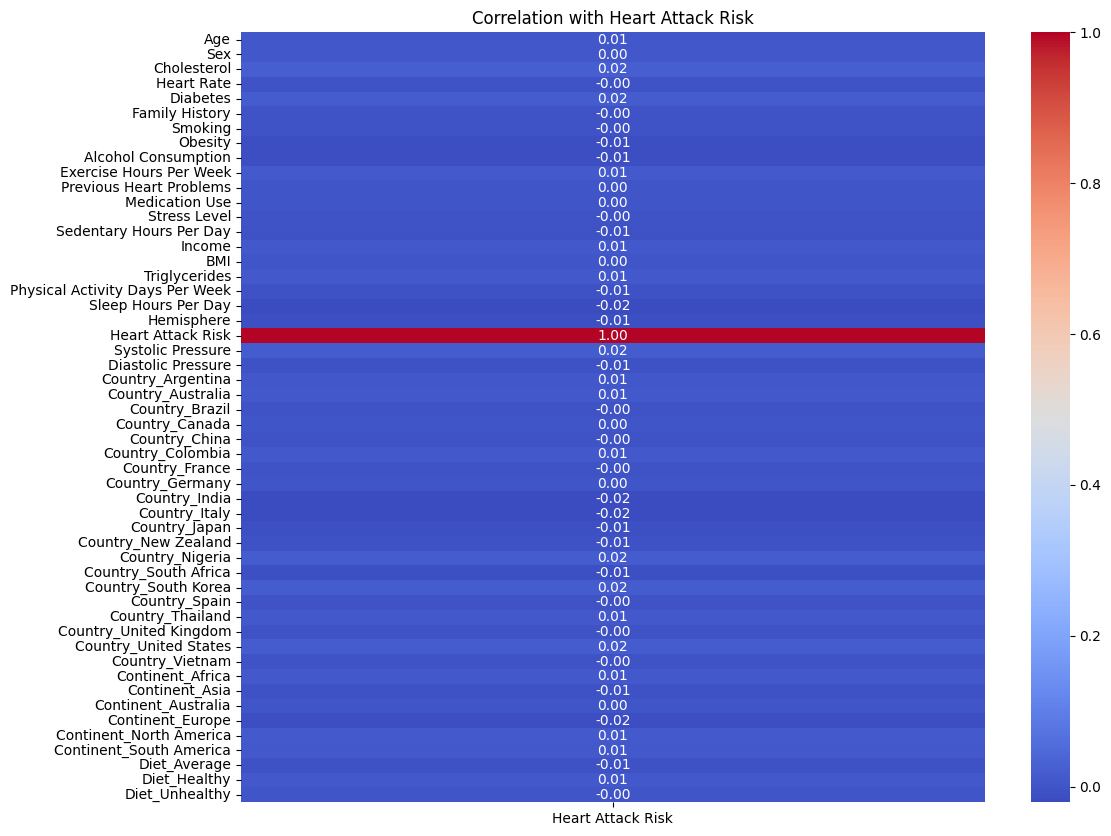

In [18]:
# Compute the correlation matrix
correlation_matrix = encoded_df.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Visualize it using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[['Heart Attack Risk']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation with Heart Attack Risk")
plt.show()


In [20]:
# Save encoded_df as a JSON file with records orientation
encoded_df.to_json("https://aws-project-4.s3.ca-central-1.amazonaws.com/encoded_df.json")

# Separate features and target variable

In [21]:
X = encoded_df.drop(['Heart Attack Risk', 'Sex', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Hemisphere',
       'Country_Argentina', 'Country_Australia', 'Country_Brazil',
       'Country_Canada', 'Country_China', 'Country_Colombia', 'Country_France',
       'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Japan',
       'Country_New Zealand', 'Country_Nigeria', 'Country_South Africa',
       'Country_South Korea', 'Country_Spain', 'Country_Thailand',
       'Country_United Kingdom', 'Country_United States', 'Country_Vietnam',
       'Continent_Africa', 'Continent_Asia', 'Continent_Australia',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America', 'Diet_Average', 'Diet_Healthy',
       'Diet_Unhealthy'], axis=1)
y = encoded_df['Heart Attack Risk']

# Split the data into training and testing sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Define features for scale
scaled_features = ['Age',
 'Cholesterol',
 'Heart Rate',
 'Exercise Hours Per Week',
 'Stress Level',
 'Sedentary Hours Per Day',
 'Income',
 'BMI',
 'Triglycerides',
 'Physical Activity Days Per Week',
 'Sleep Hours Per Day',
 'Systolic Pressure',
 'Diastolic Pressure']


In [24]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [25]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [26]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [27]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=300, random_state=78)

In [28]:
# Fit the model and use .ravel()on the "y_train" data.
rf_model = rf_model.fit(X_train_scaled, y_train)

In [29]:
# Making predictions using the testing data
rf_predictions = rf_model.predict(X_test_scaled)

In [30]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, rf_predictions)

In [31]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, rf_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1102,23
Actual 1,610,18


Accuracy Score : 0.638904734740445
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.98      0.78      1125
           1       0.44      0.03      0.05       628

    accuracy                           0.64      1753
   macro avg       0.54      0.50      0.42      1753
weighted avg       0.57      0.64      0.52      1753



In [32]:
# Get the feature importance array
importances = rf_model.feature_importances_

# List the top 10 most important features
importances_top_10 = sorted(zip(importances, X.columns), reverse=True)[:10]
print("Top 10 most important features:")
pprint(importances_top_10)

Top 10 most important features:
[(0.11080455273543065, 'BMI'),
 (0.10947995508065286, 'Sedentary Hours Per Day'),
 (0.10913066847405627, 'Exercise Hours Per Week'),
 (0.10672541536156116, 'Triglycerides'),
 (0.1062285284481457, 'Income'),
 (0.10014200226002866, 'Cholesterol'),
 (0.09338369460760643, 'Systolic Pressure'),
 (0.08990770599628052, 'Age'),
 (0.08864652498463449, 'Heart Rate'),
 (0.08555095205160324, 'Diastolic Pressure')]


# KNN model

In [33]:
X = encoded_df.drop(['Heart Attack Risk', 'Sex', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Hemisphere',
       'Country_Argentina', 'Country_Australia', 'Country_Brazil',
       'Country_Canada', 'Country_China', 'Country_Colombia', 'Country_France',
       'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Japan',
       'Country_New Zealand', 'Country_Nigeria', 'Country_South Africa',
       'Country_South Korea', 'Country_Spain', 'Country_Thailand',
       'Country_United Kingdom', 'Country_United States', 'Country_Vietnam',
       'Continent_Africa', 'Continent_Asia', 'Continent_Australia',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America', 'Diet_Average', 'Diet_Healthy',
       'Diet_Unhealthy'], axis=1)
y = encoded_df['Heart Attack Risk']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [36]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [37]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [38]:
from sklearn.neighbors import KNeighborsClassifier
# Instantiate the model with k = 3 neighbors
knn_model = KNeighborsClassifier(n_neighbors=50)

# Train the model
knn_model.fit(X_train_scaled, y_train)
# Create predictions
knn_y_pred = knn_model.predict(X_test_scaled)

In [39]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, knn_y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, knn_y_pred)

In [40]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  knn_y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1114,11
Actual 1,610,18


Accuracy Score : 0.6457501426126641
Classification Report
              precision    recall  f1-score   support

           0       0.65      0.99      0.78      1125
           1       0.62      0.03      0.05       628

    accuracy                           0.65      1753
   macro avg       0.63      0.51      0.42      1753
weighted avg       0.64      0.65      0.52      1753



# SVC model

In [41]:
X = encoded_df.drop(['Heart Attack Risk', 'Sex', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Hemisphere',
       'Country_Argentina', 'Country_Australia', 'Country_Brazil',
       'Country_Canada', 'Country_China', 'Country_Colombia', 'Country_France',
       'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Japan',
       'Country_New Zealand', 'Country_Nigeria', 'Country_South Africa',
       'Country_South Korea', 'Country_Spain', 'Country_Thailand',
       'Country_United Kingdom', 'Country_United States', 'Country_Vietnam',
       'Continent_Africa', 'Continent_Asia', 'Continent_Australia',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America', 'Diet_Average', 'Diet_Healthy',
       'Diet_Unhealthy'], axis=1)
y = encoded_df['Heart Attack Risk']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
from sklearn.svm import SVC
SVC_model = SVC(kernel='linear')
SVC_model.fit(X_train, y_train)

SVC(kernel='linear')

In [44]:
SVC_predictions = SVC_model.predict(X_test)

In [45]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, SVC_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, SVC_predictions)

In [46]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  SVC_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1096,29
Actual 1,617,11


Accuracy Score : 0.6314888762122076
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.97      0.77      1125
           1       0.28      0.02      0.03       628

    accuracy                           0.63      1753
   macro avg       0.46      0.50      0.40      1753
weighted avg       0.51      0.63      0.51      1753



# LogisticRegression

In [104]:
y = encoded_df['Heart Attack Risk']
X = encoded_df.drop(['Heart Attack Risk'], axis=1)

In [105]:
#balance labels y
balance_labels = y.value_counts()
balance_labels

0    5624
1    3139
Name: Heart Attack Risk, dtype: int64

There seems to be a bit of imbalance, with more instances of
class 0 compared to class 1. Depending on our model's sensitivity to class
imbalances, we may want to consider techniques like (1) oversampling,
(2) undersampling, or (3) using class weights during model training to handle this imbalance.

In [106]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape

(7010, 51)

7010: This is the number of samples or instances in your training set. Each row represents a separate observation or data point in your dataset.

26: This is the number of features or variables in your dataset. Each column in your dataset corresponds to a different feature or attribute that is used for training your machine learning model.

So, in summary, you have 7010 training samples, and each sample has 26 features. This information is crucial for understanding the dimensions of your training data, especially when you're working with machine learning models that require input of specific shapes.

In [107]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_model = LogisticRegression(solver="lbfgs",max_iter=200, random_state=1)

In [108]:
# Fit the model using training data
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [109]:
print(f"Training Data Score: {logistic_model.score(X_train, y_train)}")
print(f"Testing Data Score: {logistic_model.score(X_test, y_test)}")

Training Data Score: 0.6393723252496434
Testing Data Score: 0.6514546491728466


In [110]:
# Make a prediction using the testing data
lr_predictions = logistic_model.predict(X_test)
results = pd.DataFrame({"Prediction": lr_predictions, "Actual": y_test}).reset_index(drop = True)
results.head(10)

,Prediction,Actual
0,0,1
1,0,0
2,0,0
3,0,1
4,0,1
5,0,0
6,0,1
7,0,0
8,0,1
9,0,1


In [111]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, lr_predictions)

0.6514546491728466

### Evaluation of the model’s performance by doing the following:

* Calculate the accuracy score of the model.

* Generate a confusion matrix.

* Print the classification report.

In [112]:
balanced_accuracy = accuracy_score(y_test, lr_predictions)
balanced_accuracy

0.6514546491728466

In [113]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, lr_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, lr_predictions)

In [114]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test,  lr_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,1142,0
Actual 1,611,0


Accuracy Score : 0.6514546491728466
Classification Report
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1142
           1       0.00      0.00      0.00       611

    accuracy                           0.65      1753
   macro avg       0.33      0.50      0.39      1753
weighted avg       0.42      0.65      0.51      1753



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's break down what each of these means:

True Negative (TN): 18673 instances were correctly predicted as class 0 (negative class).

False Positive (FP): 86 instances were incorrectly predicted as class 1 (positive class) when they were actually class 0.

False Negative (FN): 32 instances were incorrectly predicted as class 0 when they were actually class 1.

True Positive (TP): 593 instances were correctly predicted as class 1.

Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. In your case:

Precision for class 0: 0.65 (65% of instances predicted as class 0 were actually class 0)
Precision for class 1: 0.00 (None of the instances predicted as class 1 were actually class 1)
Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to the all observations in actual class. In your case:

Recall for class 0: 1.00 (All instances of class 0 were correctly predicted)
Recall for class 1: 0.00 (None of the instances of class 1 were correctly predicted)
F1-Score: F1-Score is the weighted average of Precision and Recall. It is a balance between precision and recall. In your case:

F1-Score for class 0: 0.79 (Weighted average of precision and recall for class 0)
F1-Score for class 1: 0.00 (Weighted average of precision and recall for class 1)
Support: The number of actual occurrences of each class in the specified dataset. In your case:

Support for class 0: 1142 instances
Support for class 1: 611 instances
Accuracy: Overall accuracy of the model on the testing data. In your case: 0.65 (65%)

Macro Average: The average of precision, recall, and F1-Score for both classes, without considering class imbalance. In your case:

Macro Average Precision: 0.33
Macro Average Recall: 0.50
Macro Average F1-Score: 0.39
Weighted Average: The average of precision, recall, and F1-Score, weighted by the number of samples in each class. In your case:

Weighted Average Precision: 0.42
Weighted Average Recall: 0.65
Weighted Average F1-Score: 0.51
These metrics provide a more nuanced understanding of your model's performance for each class and overall. In this case, it seems that the model is performing well in predicting class 0 but struggling to predict class 1, as indicated by the low recall and F1-Score for class 1. Depending on the specific goals of your model, you may need to adjust the model or data preprocessing to improve its performance.

In [115]:
#Handling Imbalanced Data:

logistic_model = LogisticRegression(class_weight='balanced', random_state=1)

In [116]:
!pip install imbalanced-learn

In [117]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [118]:
# Instantiate a new logistic regression model
logistic_model_resampled = LogisticRegression(random_state=1)

# Fit the model with the resampled data
logistic_model_resampled.fit(X_resampled, y_resampled)

# Make predictions on the testing data
predictions_resampled = logistic_model_resampled.predict(X_test)

In [119]:
#Evaluate the performance
accuracy_resampled = accuracy_score(y_test, predictions_resampled)
classification_report_resampled = classification_report(y_test, predictions_resampled)
confusion_matrix_resampled = confusion_matrix(y_test, predictions_resampled)

print("Accuracy (Resampled):", accuracy_resampled)
print("Classification Report (Resampled):\n", classification_report_resampled)
print("Confusion Matrix (Resampled):\n", confusion_matrix_resampled)

Accuracy (Resampled): 0.5014261266400456
Classification Report (Resampled):
               precision    recall  f1-score   support

           0       0.66      0.49      0.56      1142
           1       0.35      0.52      0.42       611

    accuracy                           0.50      1753
   macro avg       0.51      0.51      0.49      1753
weighted avg       0.55      0.50      0.51      1753

Confusion Matrix (Resampled):
 [[559 583]
 [291 320]]
